In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tweet-sentiment-extraction/test.csv
/kaggle/input/tweet-sentiment-extraction/sample_submission.csv
/kaggle/input/tweet-sentiment-extraction/train.csv
/kaggle/input/tf-roberta/config-roberta-base.json
/kaggle/input/tf-roberta/merges-roberta-base.txt
/kaggle/input/tf-roberta/vocab-roberta-base.json
/kaggle/input/tf-roberta/pretrained-roberta-base.h5


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.model_selection import StratifiedKFold
from transformers import *
import tokenizers
print('TF version',tf.__version__)

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


TF version 2.2.0


In [3]:
MAX_LEN = 96
PATH = '../input/tf-roberta/'
tokenizer = tokenizers.ByteLevelBPETokenizer(
    vocab_file=PATH+'vocab-roberta-base.json', 
    merges_file=PATH+'merges-roberta-base.txt', 
    lowercase=True,
    add_prefix_space=True
)
sentiment_id = {'positive': 1313, 'negative': 2430, 'neutral': 7974}
train = pd.read_csv('../input/tweet-sentiment-extraction/train.csv').fillna('')
test = pd.read_csv(r'/kaggle/input/tweet-sentiment-extraction/test.csv')
sample_submission = pd.read_csv(r'/kaggle/input/tweet-sentiment-extraction/sample_submission.csv')
train.head()

textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment  
0  I`d have responded, if I were going   neutral  
1                             Sooo SAD  negative  
2                          bullying me  negative  
3                       leave me alone  negative  
4                        Sons of ****,  negative

print(tokenizer.encode('negative').ids)  O/P: 2430
print(tokenizer.encode('positive').ids)  O/P: 1313
print(tokenizer.encode('neutral').ids)   O/P: 7974

## Training Data

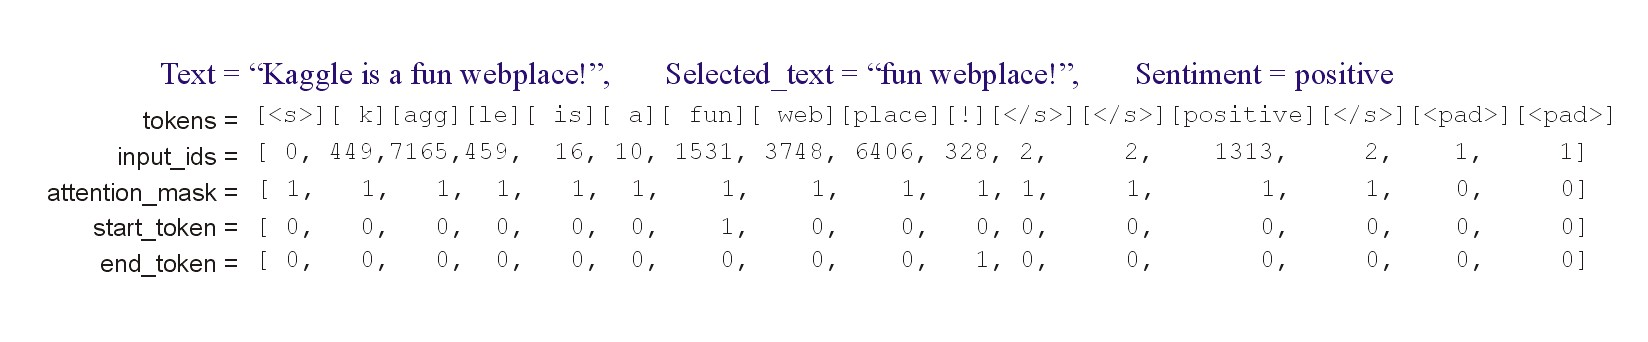

In [4]:
ct = train.shape[0]
input_ids = np.ones((ct,MAX_LEN),dtype='int32')
attention_mask = np.zeros((ct,MAX_LEN),dtype='int32')
token_type_ids = np.zeros((ct,MAX_LEN),dtype='int32')
start_tokens = np.zeros((ct,MAX_LEN),dtype='int32')
end_tokens = np.zeros((ct,MAX_LEN),dtype='int32')

for k in range(train.shape[0]):
    
    # FIND OVERLAP
    text1 = " "+" ".join(train.loc[k,'text'].split())
    text2 = " ".join(train.loc[k,'selected_text'].split())
    idx = text1.find(text2)
    chars = np.zeros((len(text1)))
    chars[idx:idx+len(text2)]=1
    if text1[idx-1]==' ': chars[idx-1] = 1 
    enc = tokenizer.encode(text1) 
        
    # ID_OFFSETS(Start and End index of the word)
    offsets = []; idx=0
    for t in enc.ids:
        w = tokenizer.decode([t])
        offsets.append((idx,idx+len(w)))
        idx += len(w)
    
    # START END TOKENS
    toks = []
    for i,(a,b) in enumerate(offsets):
        sm = np.sum(chars[a:b])
        if sm>0: toks.append(i) 
        
    s_tok = sentiment_id[train.loc[k,'sentiment']]
    input_ids[k,:len(enc.ids)+5] = [0] + enc.ids + [2,2] + [s_tok] + [2] # [0] token for <s> and [2] token for <\s>
    # Have to take input ids in the format of <s> Context </s></s> Question </s>
    attention_mask[k,:len(enc.ids)+5] = 1
    if len(toks)>0:
        start_tokens[k,toks[0]+1] = 1 # +1 because of <s> token in the beginning
        end_tokens[k,toks[-1]+1] = 1

In [5]:
print(input_ids[1])
print(attention_mask[1])
print(start_tokens[2])
print(end_tokens[2])

[    0    98  3036  5074   939    40  2649    47   259    11 15610  1597
  2977 16506     2     2  2430     2     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 1 0 0 0 0 0 

## Test Data

In [6]:
ct = test.shape[0]
input_ids_t = np.ones((ct,MAX_LEN),dtype='int32')
attention_mask_t = np.zeros((ct,MAX_LEN),dtype='int32')
token_type_ids_t = np.zeros((ct,MAX_LEN),dtype='int32')

for k in range(test.shape[0]):
        
    # INPUT_IDS
    text1 = " "+" ".join(test.loc[k,'text'].split())
    enc = tokenizer.encode(text1)                
    s_tok = sentiment_id[test.loc[k,'sentiment']]
    input_ids_t[k,:len(enc.ids)+5] = [0] + enc.ids + [2,2] + [s_tok] + [2]
    attention_mask_t[k,:len(enc.ids)+5] = 1

In [7]:
def build_model():
    ids = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    att = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    tok = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)

    config = RobertaConfig.from_pretrained(PATH+'config-roberta-base.json')
    bert_model = TFRobertaModel.from_pretrained(PATH+'pretrained-roberta-base.h5',config=config)
    x = bert_model(ids,attention_mask=att,token_type_ids=tok)
    
    x1 = tf.keras.layers.Dropout(0.15)(x[0])
    x1 = tf.keras.layers.Conv1D(768,2, padding = 'same')(x1)
    x1 = tf.keras.layers.LeakyReLU()(x1)
    x1 = tf.keras.layers.Conv1D(64,2, padding = 'same')(x1)
    x1 = tf.keras.layers.LeakyReLU()(x1)    
    x1 = tf.keras.layers.Conv1D(16,2, padding = 'same')(x1)
    x1 = tf.keras.layers.Dense(1)(x1)
    x1 = tf.keras.layers.Flatten()(x1)
    x1 = tf.keras.layers.Activation('softmax')(x1)

    x2 = tf.keras.layers.Dropout(0.15)(x[0])
    x2 = tf.keras.layers.Conv1D(768,2, padding = 'same')(x2)
    x2 = tf.keras.layers.LeakyReLU()(x2) 
    x2 = tf.keras.layers.Conv1D(16,2, padding = 'same')(x2)
    x2 = tf.keras.layers.Dense(1)(x2)
    x2 = tf.keras.layers.Flatten()(x2)
    x2 = tf.keras.layers.Activation('softmax')(x2)

    model = tf.keras.models.Model(inputs=[ids, att, tok], outputs=[x1,x2])
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer)

    return model

## Metric

In [8]:
def jaccard_score(str1, str2):
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    if (len(a)==0) & (len(b)==0): return 0.5
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [9]:
jac = []; VER='v0'; DISPLAY=1 # USE display=1 FOR INTERACTIVE
oof_start = np.zeros((input_ids.shape[0],MAX_LEN))
oof_end = np.zeros((input_ids.shape[0],MAX_LEN))
preds_start = np.zeros((input_ids_t.shape[0],MAX_LEN))
preds_end = np.zeros((input_ids_t.shape[0],MAX_LEN))

skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=88888)
for fold,(idxT,idxV) in enumerate(skf.split(input_ids,train.sentiment.values)):

    print('#'*25)
    print('### FOLD %i'%(fold+1))
    print('#'*25)
    
    K.clear_session()
    model = build_model()
        
    learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
        
    model.fit([input_ids[idxT,], attention_mask[idxT,], token_type_ids[idxT,]], [start_tokens[idxT,], end_tokens[idxT,]], 
        epochs=3, batch_size=32, verbose=DISPLAY, callbacks=[learning_rate_reduction],
        validation_data=([input_ids[idxV,],attention_mask[idxV,],token_type_ids[idxV,]], 
        [start_tokens[idxV,], end_tokens[idxV,]]))
    
    print('Predicting OOF...')
    oof_start[idxV,],oof_end[idxV,] = model.predict([input_ids[idxV,],attention_mask[idxV,],token_type_ids[idxV,]],verbose=DISPLAY)
    
    print('Predicting Test...')
    preds = model.predict([input_ids_t,attention_mask_t,token_type_ids_t],verbose=DISPLAY)
    preds_start += preds[0]/skf.n_splits
    preds_end += preds[1]/skf.n_splits
    
    # DISPLAY FOLD JACCARD
    all = []
    for k in idxV:
        a = np.argmax(oof_start[k,])
        b = np.argmax(oof_end[k,])
        if a>b: 
            st = train.loc[k,'text'] # IMPROVE CV/LB with better choice here
        else:
            text1 = " "+" ".join(train.loc[k,'text'].split())
            enc = tokenizer.encode(text1)
            st = tokenizer.decode(enc.ids[a-1:b])
        all.append(jaccard_score(st,train.loc[k,'selected_text']))
    jac.append(np.mean(all))
    print('>>>> FOLD %i Jaccard ='%(fold+1),np.mean(all))

#########################
### FOLD 1
#########################
Epoch 1/3
687/687 [==============================] - 280s 408ms/step - loss: 2.1344 - activation_loss: 1.0962 - activation_1_loss: 1.0383 - val_loss: 1.6454 - val_activation_loss: 0.8478 - val_activation_1_loss: 0.7975 - lr: 3.0000e-05
Epoch 2/3
687/687 [==============================] - 277s 404ms/step - loss: 1.6286 - activation_loss: 0.8376 - activation_1_loss: 0.7910 - val_loss: 1.6447 - val_activation_loss: 0.8406 - val_activation_1_loss: 0.8041 - lr: 3.0000e-05
Epoch 3/3
687/687 [==============================] - 277s 404ms/step - loss: 1.4907 - activation_loss: 0.7700 - activation_1_loss: 0.7206 - val_loss: 1.6706 - val_activation_loss: 0.8438 - val_activation_1_loss: 0.8267 - lr: 3.0000e-05
Predicting OOF...
172/172 [==============================] - 24s 139ms/step
Predicting Test...
111/111 [==============================] - 15s 139ms/step
>>>> FOLD 1 Jaccard = 0.697292698234593
#########################
### FOLD 2

## Kaggle Submission

In [10]:
all = []
for k in range(input_ids_t.shape[0]):
    a = np.argmax(preds_start[k,])
    b = np.argmax(preds_end[k,])
    if a>b: 
        st = test.loc[k,'text']
    else:
        text1 = " "+" ".join(test.loc[k,'text'].split())
        enc = tokenizer.encode(text1)
        st = tokenizer.decode(enc.ids[a-1:b])
    all.append(st)

In [11]:
test['selected_text'] = all
test.head()

textID                                               text sentiment  \
0  f87dea47db  Last session of the day  http://twitpic.com/67ezh   neutral   
1  96d74cb729   Shanghai is also really exciting (precisely -...  positive   
2  eee518ae67  Recession hit Veronique Branquinho, she has to...  negative   
3  01082688c6                                        happy bday!  positive   
4  33987a8ee5             http://twitpic.com/4w75p - I like it!!  positive   

                                       selected_text  
0   last session of the day http://twitpic.com/67ezh  
1                                           exciting  
2                                      such a shame!  
3                                        happy bday!  
4                                        i like it!!

In [12]:
import warnings
warnings.filterwarnings("ignore")

test[test['sentiment']=='neutral']['selected_text'] = test[test['sentiment']=='neutral']['text']

test['num_words_text'] = test['text'].str.split().apply(lambda x: len(x))
test.head()

test[test['num_words_text'] == 2]['selected_text'] = test[test['num_words_text'] == 2]['text']
test[test['num_words_text'] == 1]['selected_text'] = test[test['num_words_text'] == 1]['text']

In [13]:
test[['textID','selected_text']].to_csv('submission.csv',index=False)
pd.set_option('max_colwidth', 60)
test.sample(25)

textID                                                         text  \
2201  50dd008fb5                      laze about ! It`s. The bank holiday law   
413   481e268403   I know.  I am definitely going to try and see Up this w...   
3370  38c94c08b8    I`m back from my first 5K running race   And still alive!   
174   e77a8f8f2d  Twitter has spoiled all the fun. Frustratingly slow!!  c...   
684   6d3596cdb3  love it when my sister brags! but she`s too tired too sp...   
172   5ff525b74b  Wondering if i cld make things any worse than they alrea...   
3152  6913d9c30e         I`m saving up for a three burner weber for next year   
3026  323e67716f  I`ve been reading up on Sims 3 genetics on the Sims 2 fo...   
3135  e33459f8f1  Just left Brooklyn going uptown for some latin coffee wi...   
2571  31b002108e                                         My neck hurts a lot.   
1534  4f0c1d97c4  I should have know that 'extra hand' comment would cause...   
222   37ffa83550   thank you!! ooh I see you`ve read Desert Islands http:/...   
1496  fb6110efb9  Raaaaaaaaaaagh early morning  and its not even early!! M...   
2461  19693f5997  **** I failed in my assassination attempt on Louis  re: ...   
1906  3195d34e5b                                   Good news about the tooth!   
440   00d907ce33  Ready for tomorrow. My mommy will get her gift for Mothe...   
1033  e170fafd8c   Okaii Cool!  I Can`t Wait For The Series To Begin It`s ...   
725   17deedd7a4  I love summer, but I oddly don`t want this school year t...   
2505  2b2f63eb2c                          Ok NOW I can hit the hay. Thank you   
1584  31a107dbcf                           But on the bright side...no school   
3254  e9e0de67a2              Wish my headache/almost migraine would go away!   
2462  d1732ef2a9   i think there`s something wrong with the video, it only...   
1419  3cd2b0d233  wishing, i was at the michou show right now.. god. life ...   
865   eaf90c4253   srry im not so interesting right now... stayed up til 6...   
2259  41a86a9b67                                         i just need to sleep   

     sentiment                                                selected_text  
2201   neutral                      laze about ! it`s. the bank holiday law  
413   positive   i know. i am definitely going to try and see up this we...  
3370  positive                                                       alive!  
174   negative                                         frustratingly slow!!  
684    neutral   love it when my sister brags! but she`s too tired too s...  
172   negative   wondering if i cld make things any worse than they alre...  
3152   neutral         i`m saving up for a three burner weber for next year  
3026  negative                                        i`m very disappointed  
3135   neutral   just left brooklyn going uptown for some latin coffee w...  
2571  negative                                                 hurts a lot.  
1534  negative                                                   trouble...  
222   positive                                                  thank you!!  
1496   neutral   raaaaaaaaaaagh early morning and its not even early!! m...  
2461  negative                                                **** i failed  
1906  positive                                                         good  
440   positive                                           hope she loves it!  
1033  positive                                                      awesome  
725   positive                                               i love summer,  
2505  positive                                                    thank you  
1584  positive                                    but on the bright side...  
3254   neutral              wish my headache/almost migraine would go away!  
2462  negative                                                        wrong  
1419   neutral   wishing, i was at the michou show right now.. god. life...  
865   negative   srry im not so